In [1]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import MLFlowLogger
import torch.nn.init as init
import mlflow
import torch
import os
# os.environ["TORCH_CPP_LOG_LEVEL"]="INFO"
# os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
# from constants import * 
# from utils import reduce_memory_usage_pl
import hickle as hkl
import numpy.random as npr
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"#"cuda:2"

# DEVICE = "cpu"

In [2]:
BATCH_SIZE = 512#1000 #1024
ERR = 1e-6

In [3]:
n_column_features = 21#23
n_scalar_features = 14#16#25 #14 for losing lat/lon info
n_features = n_column_features*60+n_scalar_features
print(n_features)

1274


In [4]:
large_scale_forcing_mask = np.zeros(n_features, dtype=bool)
large_scale_forcing_mask[6*60:12*60] = True
n_column_features = 15
n_features = n_column_features*60+n_scalar_features
print(n_features)

914


In [5]:
n_column_targets = 5
n_scalar_targets = 2#8
n_targets = n_column_targets*60+n_scalar_targets
print(n_targets)

302


In [6]:
class NumpyDataset(Dataset):
    def __init__(self, x, y, mask=None):
        """
        Initialize with NumPy arrays.
        """
        assert x.shape[0] == y.shape[0], "Features and labels must have the same number of samples"
        self.x = x
        self.y = y
        self.mask = mask
        if self.mask is not None:
            print('Attention: Using mask for inputs')

    def __len__(self):
        """
        Total number of samples.
        """
        return self.x.shape[0]
    

    def __getitem__(self, index):
        """
        Generate one sample of data.
        """
        # Convert the data to tensors when requested
        x = torch.from_numpy(self.x[index]).float()#.to(DEVICE)
        # x = torch.tensor(self.x[index]).float()#.to(DEVICE)
        if self.mask is not None:
            x = x[~self.mask]
        y = torch.from_numpy(self.y[index]).float()#.to(DEVICE)
        # y = torch.tensor(self.y[index]).float()#.to(DEVICE)
        x = torch.cat(
            [
                x[:n_column_features*60].reshape(n_column_features, 60).permute(1, 0),
                x[n_column_features*60:].unsqueeze(1).repeat(60, 1).view(60, n_scalar_features),
            ],
            -1,
        )
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        return x, y

# # x_train = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_normed.npy')
# x_train = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_nols_normed.npy')#, mmap_mode='r')
# x_train = x_train[:,:-2]
# y_train = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed.npy')#, mmap_mode='r')

# x_val = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_input_normed.npy')
x_val = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_input_nols_pmidcommonnorm_normed.npy')#, mmap_mode='r')
x_val = x_val[:,:-2]
y_val = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_target_normed.npy')#, mmap_mode='r')
x_val = x_val[:512*1000]
y_val = y_val[:512*1000]

x_test = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_input_nols_pmidcommonnorm_normed.npy')#, mmap_mode='r')
x_test = x_test[:,:-2]
y_test = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_target_normed.npy')#, mmap_mode='r')
x_test = x_test[:512*1000]
y_test = y_test[:512*1000]

# npr.seed(4123)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
# print('Train shape', x_train.shape, y_train.shape)
print('valataion shape', x_val.shape, y_val.shape)
print('test shape', x_test.shape, y_test.shape)

# BATCH_SIZE = 2048

val_dataset = NumpyDataset(x_val, y_val)#, mask=large_scale_forcing_mask)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset = NumpyDataset(x_test, y_test)#, mask=large_scale_forcing_mask)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# train_dataset = NumpyDataset(x_train, y_train)#, mask=large_scale_forcing_mask)
# # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0,
#                           sampler=torch.utils.data.RandomSampler(
#                               data_source=train_dataset,
#                               num_samples=int(2e6)
#                           ))

valataion shape (512000, 914) (512000, 302)
test shape (512000, 914) (512000, 302)


In [7]:
x_val_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/val_input_nols_pmidcommonnorm_normed.npy')#, mmap_mode='r')
x_val_icon = x_val_icon[:,:-2]
y_val_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/val_target_normed.npy')#, mmap_mode='r')
x_val_icon = x_val_icon[:512*1000]
y_val_icon = y_val_icon[:512*1000]

x_test_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/test_input_nols_pmidcommonnorm_normed.npy')#, mmap_mode='r')
x_test_icon = x_test_icon[:,:-2]
y_test_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/test_target_normed.npy')#, mmap_mode='r')
x_test_icon = x_test_icon[:512*1000]
y_test_icon = y_test_icon[:512*1000]

# npr.seed(4123)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
# print('Train shape', x_train.shape, y_train.shape)
print('valataion shape', x_val_icon.shape, y_val_icon.shape)
print('test shape', x_test_icon.shape, y_test_icon.shape)

val_dataset_icon = NumpyDataset(x_val_icon, y_val_icon)#, mask=large_scale_forcing_mask)
val_loader_icon = DataLoader(val_dataset_icon, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset_icon = NumpyDataset(x_test_icon, y_test_icon)#, mask=large_scale_forcing_mask)
test_loader_icon = DataLoader(test_dataset_icon, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

valataion shape (512000, 914) (512000, 302)
test shape (512000, 914) (512000, 302)


In [8]:
# val_dataset = NumpyDataset(x_valid, y_valid)#, mask=large_scale_forcing_mask)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# train_dataset = NumpyDataset(x_train, y_train)#, mask=large_scale_forcing_mask)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [9]:
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_normed_4samples.npy', x_train[:4])
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_4samples.npy', y_train[:4])

In [10]:
Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_my.npy'))
Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_sy.npy'))

In [30]:
# JOINT_MASK = MASK * ADJUSTMENT_MASK

# seq_fea_list = ['state_t','state_q0001','state_q0002','state_q0003','state_u','state_v','pbuf_ozone','pbuf_CH4','pbuf_N2O']
# num_fea_list = ['state_ps','pbuf_SOLIN','pbuf_LHFLX','pbuf_SHFLX','pbuf_TAUX','pbuf_TAUY','pbuf_COSZRS','cam_in_ALDIF','cam_in_ALDIR',
#                 'cam_in_ASDIF','cam_in_ASDIR','cam_in_LWUP','cam_in_ICEFRAC','cam_in_LANDFRAC','cam_in_OCNFRAC','cam_in_SNOWHLAND']
# seq_y_list = ['ptend_t','ptend_q0001','ptend_qn','ptend_q0003','ptend_u','ptend_v']
# num_y_list = ['cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

# zeroout_index = list(range(145,147)) #Indices to just have a 0 output
zeroout_index = list(range(60,75)) + list(range(120,135)) + list(range(180,195)) + list(range(240,255))#Indices to just have a 0 output
zeroout_index = torch.tensor(zeroout_index)
# zeroout_mask = torch.zeros(n_column_targets*60+n_scalar_targets)
# zeroout_mask[zeroout_index] = 1
# non_zeroout_index = torch.where(zeroout_mask==0)

class FFNN_LSTM_6_AVG(nn.Module):
    def __init__(self, feature_target_lengths, zeroout_index, nlev):
        super(FFNN_LSTM_6_AVG, self).__init__()
        self.nlev = nlev

        # # 13.6M model
        # self.encode_dim = 300
        # self.hidden_dim = 280
        # self.iter_dim = 800
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,6,batch_first=True,dropout=0.01,bidirectional=True)

        # # 8M model
        # self.encode_dim = 300
        # self.hidden_dim = 280
        # self.iter_dim = 800
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,3,batch_first=True,dropout=0.01,bidirectional=True)
        
        # # 1.2M model
        # self.encode_dim = 200
        # self.hidden_dim = 100
        # self.iter_dim = 300
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,3,batch_first=True,dropout=0.01,bidirectional=True)
        
        # # 0.5M model
        # self.encode_dim = 200
        # self.hidden_dim = 50
        # self.iter_dim = 190
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,5,batch_first=True,dropout=0.01,bidirectional=True)
        
        # # 3.3M model
        # self.encode_dim = 200
        # self.hidden_dim = 100
        # self.iter_dim = 1000
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,2,batch_first=True,dropout=0.01,bidirectional=True)
        
        # # 3.3M model - 2
        # self.encode_dim = 150
        # self.hidden_dim = 150
        # self.iter_dim = 600
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,4,batch_first=True,dropout=0.01,bidirectional=True)
        
        # # 5.5M model
        # self.encode_dim = 150
        # self.hidden_dim = 150
        # self.iter_dim = 600
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,4,batch_first=True,dropout=0.01,bidirectional=True)
        
#         # 6M model
#         self.encode_dim = 300
#         self.hidden_dim = 350
#         self.iter_dim = 400
#         self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,2,batch_first=True,dropout=0.01,bidirectional=True)
        
#         # 7.1M model
#         self.encode_dim = 200
#         self.hidden_dim = 350
#         self.iter_dim = 700
#         self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,2,batch_first=True,dropout=0.01,bidirectional=True)
        
#         # 7M model
#         self.encode_dim = 350
#         self.hidden_dim = 300
#         self.iter_dim = 400
#         self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,3,batch_first=True,dropout=0.01,bidirectional=True)

        #   # 0.24M model
        # self.encode_dim = 20
        # self.hidden_dim = 60
        # self.iter_dim = 160
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,2,batch_first=True,dropout=0.01,bidirectional=True)
        
        # 0.98M model
        self.encode_dim = 160
        self.hidden_dim = 90
        self.iter_dim = 190
        self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,4,batch_first=True,dropout=0.13,bidirectional=True)
        # self.LSTM_1 = nn.LSTM(self.encode_dim,self.hidden_dim,4,batch_first=True,dropout=0.,bidirectional=True)

        self.n_column_features, self.n_scalar_features, self.n_column_targets, self.n_scalar_targets = \
            feature_target_lengths
        self.zeroout_index = zeroout_index
        self.input_size = self.n_column_features*self.nlev + self.n_scalar_features
        self.output_size = self.n_column_targets*self.nlev + self.n_scalar_targets
        
        self.Linear_1 = nn.Linear(self.n_column_features+self.n_scalar_features, self.encode_dim)
        self.Linear_2 = nn.Linear(6*self.hidden_dim+self.encode_dim, self.iter_dim)
        self.Linear_3 = nn.Linear(self.iter_dim, self.n_column_targets)
        self.Linear_4_0 = nn.Linear(self.iter_dim, self.iter_dim*2)

        self.Linear_4 = nn.Linear(self.iter_dim*2, self.n_scalar_targets)
        
        self.weight = nn.Parameter(torch.zeros(1,self.output_size))
        self.bias = nn.Parameter(torch.zeros(1,self.output_size))
        torch.nn.init.xavier_uniform(self.weight)
        torch.nn.init.xavier_uniform(self.bias)
        # self.bias = nn.Linear(len(seq_y_list)*self.nlev+len(num_y_list),1)
        # self.weight = nn.Linear(len(seq_y_list)*self.nlev+len(num_y_list),1)
        
        self.avg_pool_1 = nn.AvgPool1d(kernel_size=3,stride=1,padding=1)
        
    def forward(self, x):
#         x_seq = x[:,0:60*len(seq_fea_list)]
#         x_seq = x_seq.reshape((-1,len(seq_fea_list),60))
#         x_seq = torch.transpose(x_seq, 1, 2)
        
#         x_num = x[:,self.nlev*len(seq_fea_list):x.shape[1]]
#         x_num_repeat = x_num.reshape((-1,1,len(num_fea_list)))
#         x_num_repeat = x_num_repeat.repeat((1,self.nlev,1))
        
        # x_seq = F.elu(self.Linear_1(torch.concat((x_seq,x_num_repeat),dim=-1)/5))
        # dims: b->batch, v->variable, h->height, e->encode
        # print(x.shape) # (b,h,v)
        x_seq = F.elu(self.Linear_1(x)) # (b,h,e)
        
        # self.LSTM_1.flatten_parameters()
        x_seq_1,_ = self.LSTM_1(x_seq/5)
        
        x_seq_1_mean = torch.mean(x_seq_1,dim=1,keepdim=True)
        x_seq_1_mean = x_seq_1_mean.repeat((1,self.nlev,1))

        x_seq_1_avg_pool = self.avg_pool_1(torch.transpose(x_seq_1, 1, 2))
        x_seq_1_avg_pool = torch.transpose(x_seq_1_avg_pool,1, 2)
        
        x_seq_1 = F.elu(self.Linear_2(torch.cat((x_seq_1,x_seq_1_mean,x_seq,x_seq_1_avg_pool),dim=-1)/5))
        
        x_seq_out = self.Linear_3(x_seq_1)
        x_seq_out = torch.transpose(x_seq_out, 1, 2)
        x_seq_out = x_seq_out.reshape((-1,self.nlev*self.n_column_targets)) # (b,seq_out)
        
        x_num_out = F.elu(self.Linear_4_0(torch.mean(x_seq_1,dim=1)))
        x_num_out = self.Linear_4(x_num_out) # (b,num_out)

        # print(x_seq_out.shape, x_num_out.shape)
        # output = self.weight.weight*(torch.concat((x_seq_out,x_num_out),dim=-1))/3+self.bias.weight/3
        output = self.weight*(torch.concat((x_seq_out,x_num_out),dim=-1))/3+self.bias/3
        # output = torch.concat((x_seq_out,x_num_out),dim=-1)
        
        output[:,self.zeroout_index] = output[:,self.zeroout_index]*0.0
        
        return output

class HighResLeapModel(LightningModule):
    def __init__(self, feature_target_lengths, zeroout_index, nlev=60, use_confidence=False):
        super().__init__()
        self.nlev = nlev
        self.n_column_features, self.n_scalar_features, self.n_column_targets, self.n_scalar_targets = \
            feature_target_lengths
        self.input_size = self.n_column_features*self.nlev + self.n_scalar_features
        self.output_size = self.n_column_targets*self.nlev + self.n_scalar_targets
        self.zeroout_index = zeroout_index
        self.zeroout_mask = torch.zeros(n_column_targets*60+n_scalar_targets, dtype=bool)
        self.zeroout_mask[zeroout_index] = 1
        # self.lrs = []

        self.use_confidence = use_confidence
        # For confidence loss:
        if self.use_confidence:
            self.n_column_targets *= 2
            self.n_scalar_targets *= 2

        feature_target_lengths = \
            self.n_column_features, self.n_scalar_features, self.n_column_targets, self.n_scalar_targets
        self.network = FFNN_LSTM_6_AVG(feature_target_lengths, zeroout_index, nlev)
        
        if self.use_confidence:
            self.criterion = nn.HuberLoss(delta=1., reduction='none')
            self.mae_loss = nn.L1Loss(reduction='none')
        else:
            self.criterion = nn.HuberLoss(delta=1.)

    def forward(self, x):
        output = self.network(x)
        if self.use_confidence:
            output[:,self.output_size:] = F.relu(output[:,self.output_size:])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        # print(x.size(), y.size())
        # y = y.view(y.size(1)*y.size(0), y.size(2))
        # x = x.view(x.size(1)*x.size(0), x.size(2), x.size(3))
        y_pred = self(x)
        # loss = self.criterion(y_pred[:, JOINT_MASK==1], y[:, JOINT_MASK==1])
#             predloss = self.criterion(yhat[:, self.zeroout_mask==0], y[:, self.zeroout_mask==0])
#             predloss = torch.mean(predloss, dim=0)
#             confloss = self.criterion(yloss[:, self.zeroout_mask==0], predloss)
#             loss = torch.mean(predloss+confloss)
        if self.use_confidence:
            # confidence loss
            yhat = y_pred[:,:(self.n_column_targets*self.nlev+self.n_scalar_targets)//2]
            ylhat = y_pred[:,(self.n_column_targets*self.nlev+self.n_scalar_targets)//2:]
            
            yhat = yhat[:,~self.zeroout_mask]
            ylhat = ylhat[:,~self.zeroout_mask]
            y = y[:,~self.zeroout_mask]
            
            yhatloss = self.criterion(yhat, y)
            # confloss computation
            # yhatloss = torch.mean(yhatloss, dim=0)
            # 1. predict actual huberloss
            confloss = self.criterion(ylhat, yhatloss)
            # 2. predict MAE
            # yhatloss_mae = self.mae_loss(yhat, y)
            # confloss = self.criterion(ylhat, yhatloss_mae)
            # end confloss computation
            loss = torch.mean(yhatloss+confloss)
            
            # From 1st place:
            # def loss_fn(x, preds):
            #     confidence = preds[:, col_num_y:]
            #     preds = preds[:, :col_num_y]
            #     loss = tf.math.abs(x-preds)
            #     loss = loss*loss_mask
            #     loss_2 = tf.math.abs(loss-confidence)
            #     loss_2 = loss_2*loss_mask
            #     return tf.reduce_mean(loss+loss_2)
            self.log('train_loss_yhat', torch.mean(yhatloss), prog_bar=True, on_epoch=True, on_step=False, logger=True)
        else: # normal loss
            y_pred = y_pred[:,~self.zeroout_mask]
            y = y[:,~self.zeroout_mask]
            loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
        
        # self.lrs.append(self.lr_schedulers().get_last_lr())
        # with open('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/lr_step.txt', 'a') as f:
        #     f.write(f'{self.lr_schedulers().get_last_lr()}\n')
        
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        self.eval()
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        # print(x.size(), y.size())
        # y = y.view(y.size(1)*y.size(0), y.size(2))
        # x = x.view(x.size(1)*x.size(0), x.size(2), x.size(3))
        
        # if torch.cuda.is_available(): # GPU time (if using GPU)
        #     torch.cuda.synchronize()
        #     start_gpu_time = time.time()
        # else: # CPU time
        #     start_cpu_time = time.time()
    
        with torch.no_grad():
            y_pred = self(x)
        
        # if torch.cuda.is_available(): # Measure GPU time (if using GPU)
        #     torch.cuda.synchronize()
        #     gpu_inference_time = time.time() - start_gpu_time
        #     self.gpu_times.append(gpu_inference_time)
        # else: # Measure CPU time
        #     cpu_inference_time = time.time() - start_cpu_time
        #     self.cpu_times.append(cpu_inference_time)
            
        if self.use_confidence:
            yhat = y_pred[:,:(self.n_column_targets*self.nlev+self.n_scalar_targets)//2]
            ylhat = y_pred[:,(self.n_column_targets*self.nlev+self.n_scalar_targets)//2:]
        
        # print(yhat.mean())
        # print(yhat[0,0])
        # print(x.mean())
        
        y_std = Y_STD.to(y.device)
        y_mean = Y_MEAN.to(y.device)
        
        y = (y * y_std) + y_mean
        yhat[:, y_std < (1.1 * ERR)] = 0
        yhat = (yhat * y_std) + y_mean

        val_score = r2_score(yhat, y)
        self.log('val_score', val_score, on_epoch=True, on_step=False, sync_dist=True, add_dataloader_idx=True)#, logger=True, prog_bar=True)

        yhatloss = self.criterion(yhat, y)
        confloss = self.criterion(ylhat, yhatloss)
        loss = torch.mean(yhatloss+confloss)
        self.log('val_loss_yhat', torch.mean(yhatloss), on_epoch=True, on_step=False, sync_dist=True, add_dataloader_idx=True)
        self.log('val_loss', loss, on_epoch=True, on_step=False, sync_dist=True, add_dataloader_idx=True)

        # yhat[:, ADJUSTMENT_MASK==0] = y[:, ADJUSTMENT_MASK==0]

        # yhat[:, MASK==0] = 0
        # y[:, MASK==0] = 0
        yhat[:, self.zeroout_index] = 0
        y[:, self.zeroout_index] = 0

        
        masked_val_score = r2_score(yhat, y)
        # self.val_score.append(val_score)
        # self.masked_val_score.append(masked_val_score)
        self.log('masked_val_score', masked_val_score, on_epoch=True, on_step=False, sync_dist=True, add_dataloader_idx=True)#, logger=True, prog_bar=True)
        # return {"val_score": val_score, "masked_val_score": masked_val_score}
        # self.log('n_model_params', self.n_model_params, on_epoch=True, on_step=False, add_dataloader_idx=True)#, logger=True, prog_bar=True)
        return val_score

    def configure_optimizers(self):

#         ###################################
#         LEARNING_RATE = 6.5e-4

#         optimizer = optim.AdamW(self.parameters(), lr=LEARNING_RATE, weight_decay=2e-3)

        # # milestones = [3, 6, 8, 11, 14, 17]
        # milestones = [5, 10, 15, 20, 25, 30]
        # gamma = 0.65
        # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
        
        # optimizer = optim.AdamW(self.parameters(), lr=LEARNING_RATE, weight_decay=2e-3)
        # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2)

        # return [optimizer], [scheduler]
        
#         optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.0002)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)
        
#         return {
#             "optimizer": optimizer,
#             "lr_scheduler" : {
#                 "scheduler": scheduler,
#                 "monitor": "val_score"
#             },
#         }

#         optimizer = optim.AdamW(self.parameters(), lr=0.005, weight_decay=0.0002)
#         scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5000, T_mult=2)

#         return {
#             "optimizer": optimizer,
#             "lr_scheduler" : {
#                 "scheduler": scheduler,
#                 "interval": "step"
#             },
#         }
        
        optimizer = optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=2)
        return {
            "optimizer": optimizer,
            "lr_scheduler" : {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_score"
            },
        }

In [31]:
def r2_score(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [33]:
params = {
    "input_dim": 25,
    "hidden_dim": 512,
    "output_dim": 368,
    "num_layers": 3,
    # "max_epochs": NUM_EPOCHS,
    "accelerator": "gpu",
    "devices": [1],#[0,1,2,3],
    # 'data_length' : len(ds_data),
    'weight_decay' : 2e-3,
    'dropout' : 0.0
}

# model = LeapModel(
#     input_dim=params["input_dim"],
#     hidden_dim=params["hidden_dim"],
#     output_dim=params["output_dim"],
#     num_layers=params["num_layers"],
# )

feature_target_lengths = [n_column_features,  n_scalar_features, n_column_targets, n_scalar_targets]

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_8e6params_nolargescalef_confl/val_score=0.8484-best_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_8e6params_nolargescalef_conflnoavrelu_train-loss-split_1gpu_1/val_score=0.6601-best_model.ckpt'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_0.5e6params_nolargescalef_confhuberrelu_train-loss-split_1gpu_1Msamples/val_score=0.6408-best_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_0.5e6params_nolargescalef_confhuberrelu_train-loss-split_1gpu_5Msamples2/val_score=0.7227-best_model.ckpt'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/hr_expandcnv_3.3M-2_wolatwpres_nolargescalef_cosanh5000-2_512bs_lr5e-3_wd2e-4_confrelu_train-loss-split_1gpu_2.5Mconstsamples_20241123-202101/val_score=0.8122-best_model.ckpt'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/hr_expandcnv_0.98M_wolatwpres_nolargescalef_512bs_lr5e-3_wd2e-4_confrelu_1gpu_3Mconstsamples_0.6mix_iconpmidnorm_20241213-171118/val_score=0.0000-best_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/hr_expandcnv_0.98M_wolatwpres_nolargescalef_512bs_lr1e-3_wd1e-2_confrelu_1gpu_3Mconstsamples_0.6mix_iconpmidnorm_20241216-095822/val_score/dataloader_idx_0=0.7924-best_model.ckpt'

load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/hr_expandcnv_0.98M_wolatwpres_nolargescalef_512bs_lr1e-3_wd1e-2_confrelu_1gpu_3Mconstsamples_0.6mix_pmidcommonnorm_20241217-092530/val_score/dataloader_idx_0=0.7920-best_model.ckpt'

model = HighResLeapModel.load_from_checkpoint(checkpoint_path=load_path,
                                              # input_size=params["input_dim"],
                                              feature_target_lengths=feature_target_lengths,
                                              zeroout_index=zeroout_index,
                                              use_confidence=True,
                                              map_location=torch.device('cpu'))

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_8e6params_nolargescalef/val_score=0.8394-best_model.ckpt'
# model = HighResLeapModel.load_from_checkpoint(checkpoint_path=load_path,
#                                               feature_target_lengths=feature_target_lengths,
#                                               zeroout_index=zeroout_index,
#                                               map_location=torch.device('cpu'))
model

/tmp/ipykernel_21546/2101497443.py:109: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.weight)
/tmp/ipykernel_21546/2101497443.py:110: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.bias)


HighResLeapModel(
  (network): FFNN_LSTM_6_AVG(
    (LSTM_1): LSTM(160, 90, num_layers=4, batch_first=True, bidirectional=True)
    (Linear_1): Linear(in_features=29, out_features=160, bias=True)
    (Linear_2): Linear(in_features=700, out_features=190, bias=True)
    (Linear_3): Linear(in_features=190, out_features=10, bias=True)
    (Linear_4_0): Linear(in_features=190, out_features=380, bias=True)
    (Linear_4): Linear(in_features=380, out_features=4, bias=True)
    (avg_pool_1): AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (criterion): HuberLoss()
  (mae_loss): L1Loss()
)

In [34]:
count_parameters(model) # 1162429
# 7959351

984172

# Evaluate

In [17]:
%%time
trainer = Trainer(
    # accumulate_grad_batches=8,
    # max_epochs=params["max_epochs"],
    accelerator=params["accelerator"],
    devices=params["devices"],
    # accelerator='cpu',
    enable_checkpointing=True,
    precision=16,
    # callbacks=[checkpoint_callback, early_stopping_callback],
    # strategy='ddp_find_unused_parameters_true'
)

trainer.validate(model=model, dataloaders=[test_loader_icon]);

/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/ ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     masked_val_score      │    0.6143770217895508     │
│         val_loss          │    0.24399536546798892    │
│       val_loss_yhat       │    0.1452406543033172     │
│         val_score         │    0.6143785119056702     │
└───────────────────────────┴───────────────────────────┘

CPU times: user 3min 9s, sys: 34.6 s, total: 3min 44s
Wall time: 4min 17s


In [18]:
print(torch.cuda.is_initialized())

True


In [35]:
def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v

In [36]:
%%time
from sklearn.metrics import r2_score as sk_r2

# torch.set_float32_matmul_precision("medium")
y_trues = []
modelout = []
y_losses = []
mae_loss = nn.L1Loss(reduction='none')
ymae_losses = []
model.eval()
model.to(DEVICE)
for batch in tqdm(itr_merge(test_loader, test_loader_icon), total=len(test_loader)+len(test_loader_icon)):
    x, y = batch
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    # print(x.size(), y.size())
    # y = y.view(y.size(1)*y.size(0), y.size(2))
    # x = x.view(x.size(1)*x.size(0), x.size(2), x.size(3))
    with torch.no_grad():#, torch.autocast(device_type=DEVICE, dtype=torch.float16, enabled=True):
        y_pred = model(x)
        y_loss = model.criterion(y_pred[...,:302], y)
        ymae_loss = mae_loss(y_pred[...,:302], y)
        
    # print(sk_r2(y.detach().cpu().numpy(), y_pred[...,:302].detach().cpu().numpy()))
    # print(r2_score(y_pred[...,:302], y))
    # print(y.mean())
    # print(y_pred[...,:302].mean())
    # print(y_pred[0,0])
    # print(x.mean())
    modelout.append(y_pred.detach().cpu().numpy())
    y_trues.append(y.detach().cpu().numpy())
    y_losses.append(y_loss.detach().cpu().numpy())
    ymae_losses.append(ymae_loss.detach().cpu().numpy())
    
y_trues = np.concatenate(y_trues)
modelout = np.concatenate(modelout)
y_losses = np.concatenate(y_losses)
ymae_losses = np.concatenate(ymae_losses)
y_preds = modelout[:,:302]
y_conf = modelout[:,302:]
y_trues.shape, modelout.shape, y_losses.shape, ymae_losses.shape, sk_r2(y_trues, y_preds)
# Wall time: 4min 28s

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:04<00:00, 31.25it/s]


CPU times: user 1min 4s, sys: 7.82 s, total: 1min 11s
Wall time: 1min 12s


((1024000, 302),
 (1024000, 604),
 (1024000, 302),
 (1024000, 302),
 0.696422444213014)

In [37]:
# y_preds_eval = y_preds.copy()
# y_preds_noeval = y_preds.copy()
# y_preds_noeval0do = y_preds.copy()

In [21]:
# # np.savez('./data/losses.npz', y_trues=y_trues, modelout=modelout, y_losses=y_losses, ymae_losses=ymae_losses)
# data = np.load('./data/losses.npz')
# y_trues, modelout, y_losses, ymae_losses = data['y_trues'], data['modelout'], data['y_losses'], data['ymae_losses']
# y_preds = modelout[:,:302]
# y_conf = modelout[:,302:]
# y_trues.shape, modelout.shape, y_losses.shape, ymae_losses.shape

In [22]:
# y_trues_t_per_day = y_trues[1:2,:60]/temperature_scale*3600*24
# y_trues_t_per_day

In [23]:
# y_preds_t_per_day = y_preds[0:1,:60]/temperature_scale*3600*24
# y_preds_t_per_day

In [24]:
r2_score(torch.tensor(y_preds), torch.tensor(y_trues))
# 0.6254550218582153 0.6255626678466797

0.587175726890564

In [25]:
# todo apply masking of preds for export script as well
Y_MEAN_ICON = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/train_target_my.npy')
Y_STD_ICON = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/train_target_sy.npy')

In [26]:
# y_trues[:,Y_STD_ICON < 1e-1] = 0
# y_preds[:,Y_STD_ICON < 1e-9] = 0
# y_preds[:,r2vals < 0] = 0
r2vals = sk_r2(y_trues, y_preds, multioutput='raw_values')
r2score = np.mean(r2vals)

y_std = Y_STD.numpy()
y_mean = Y_MEAN.numpy()

# y_trues = (y_trues * y_std) + y_mean
y_preds[:, y_std < (1.1 * ERR)] = 0
# y_preds = (y_preds * y_std) + y_mean

r2vals_capped = sk_r2(y_trues, y_preds, multioutput='raw_values')
r2score_capped = np.mean(r2vals_capped)

# y_preds[:, ADJUSTMENT_MASK==0] = y[:, ADJUSTMENT_MASK==0]
# y_preds[:, MASK==0] = 0
# y_preds[:, zeroout_index] = y_trues[:, zeroout_index]
y_preds[:, zeroout_index] = 0

r2score_masked = sk_r2(y_trues, y_preds)

r2score, r2score_capped, r2score_masked

# m1
## val
# (0.7169175372936774, 0.7169175372936774, 0.7169175372936774)
# (0.7226339213940044, 0.7226339213940044, 0.7226339213940044)

# m2
## val
# (0.7285874948986045, 0.7285874948986045, 0.7285874948986045)
# (0.7355197878144123, 0.7355197878144123, 0.7355197878144123)

# (0.7779379035439149, 0.7779379035439149, 0.7779379035439149)
# (-1.366099717560792e+35, -1.366099717560792e+35, -1.366099717560792e+35)

(0.6802358168352817, 0.6802358168352817, 0.6802358168352817)

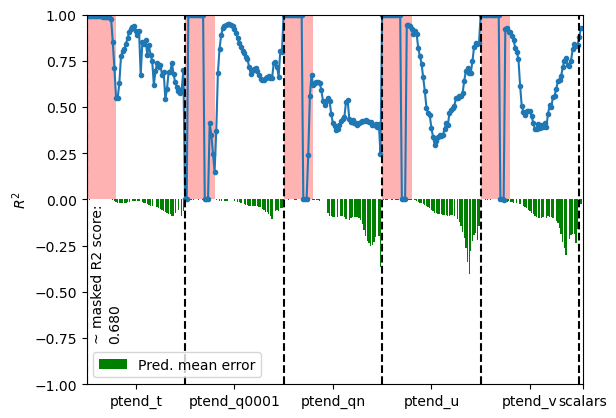

In [27]:
v5vec_outputs = ['ptend_t',
              'ptend_q0001',
              'ptend_qn',
              'ptend_u',
              'ptend_v',
]

v5scal_outputs = [
              # 'cam_out_NETSW',
              # 'cam_out_FLWDS',
              'cam_out_PRECSC',
              'cam_out_PRECC',
              # 'cam_out_SOLS',
              # 'cam_out_SOLL',
              # 'cam_out_SOLSD',
              # 'cam_out_SOLLD',
]

plt.plot(r2vals, 'o-', ms=3)
conf_mean = np.mean(y_conf, axis=0)
# plt.fill_between(range(len(r2vals)), r2vals-conf_mean, r2vals+conf_mean, alpha=0.3)
plt.bar(range(len(r2vals)), -conf_mean, color='green', label='Pred. mean error')
plt.ylim(-1,1)
plt.xlim(0,len(v5vec_outputs)*60+len(v5scal_outputs))

for i in range(len(v5vec_outputs)+1):
    plt.axvline(i*60, ls='--', c='black')
    if i < len(v5vec_outputs):
        plt.bar([i*60], [1], width=18, align='edge', color='red', alpha=0.3, zorder=-1)

# plt.bar(range(len(Y_STD_ICON)), Y_STD_ICON < 1e-10)

plt.xticks([60*i+30 for i in range(len(v5vec_outputs))] + [60*len(v5vec_outputs)+2], v5vec_outputs+['scalars'])
plt.text(0.01, 0.12, f'~ masked R2 score:\n{r2score_masked:.3f}', transform=plt.gca().transAxes, rotation='vertical')
plt.ylabel('$R^2$')
plt.legend()
# for i,out in enumerate(v5scal_outputs):
#     plt.axvline(len(v5vec_outputs)*60+i, ls='--')
# plt.savefig(f'../../Figures/offline_r2_v5expandcnv_team5reduced_confidence.jpg', bbox_inches="tight")

plt.show()

In [28]:
y_preds.shape, y_conf.shape

((5362240, 302), (5362240, 302))

In [29]:
# Mask first 18 levels for all 3d vars to mask out everything above troposphere (see code later in this notebook)

trop_mask = np.ones(302, dtype=bool)
for i in range(5):
    trop_mask[i*60:i*60+18] = False

In [30]:
import matplotlib as mpl
def fix_hist_step_vertical_line_at_end(ax):
    axpolygons = [poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)]
    for poly in axpolygons:
        poly.set_xy(poly.get_xy()[:-1])

In [31]:
sorted_confpred = np.sort(np.mean(y_conf[:,trop_mask], axis=1))

plot_quantiles = np.linspace(0,0.99,100)
plot_idx_quantiles = (plot_quantiles*len(sorted_confpred)).astype(int)
# plot_quantiles, plot_idx_quantiles

mean


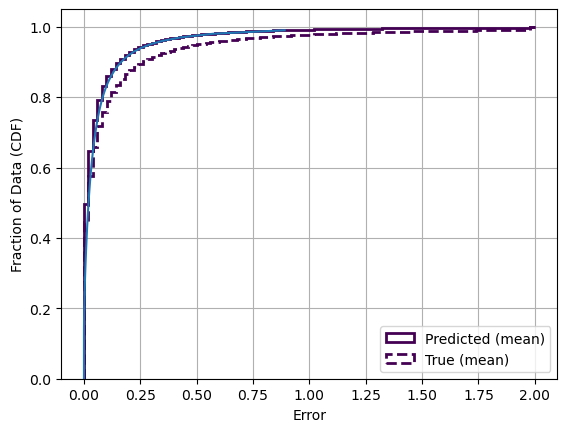

In [32]:
cmap = plt.get_cmap('viridis')

for i,func in enumerate(['mean']):#, '50p', '75p', '90p']):
    if func == 'mean':
        print(func)
        reduction = np.mean
    else:
        print(func[:-1])
        reduction = lambda x, **kwargs: np.quantile(x, q=float(func[:-1])/100, **kwargs)

    pred_plot = np.clip(reduction(y_conf[:,trop_mask], axis=1), 0, 2)
    real_plot = np.clip(reduction(y_losses[:,trop_mask], axis=1), 0, 2)

    plt.hist(pred_plot, bins=100, histtype='step', cumulative=True, density=True, color=cmap(i/4), ls='-', lw=2, label=f'Predicted ({func})')
    plt.hist(real_plot, bins=100, histtype='step', cumulative=True, density=True, color=cmap(i/4), ls='--', lw=2, label=f'True ({func})')

plt.plot(sorted_confpred[plot_idx_quantiles], plot_quantiles)

fix_hist_step_vertical_line_at_end(plt.gca())

plt.xlabel('Error')
plt.ylabel('Fraction of Data (CDF)')
plt.legend()
plt.grid()

# plt.savefig('../../Figures/relabs_error_prediction_columnaverage_troposphere.jpg')
# plt.savefig('../../Figures/relabs_error_prediction_clipped_troposphere.jpg')
# plt.savefig('../../Figures/error_prediction_clipped_troposphere.jpg')

plt.show()

[0.0199207  1.01263884]


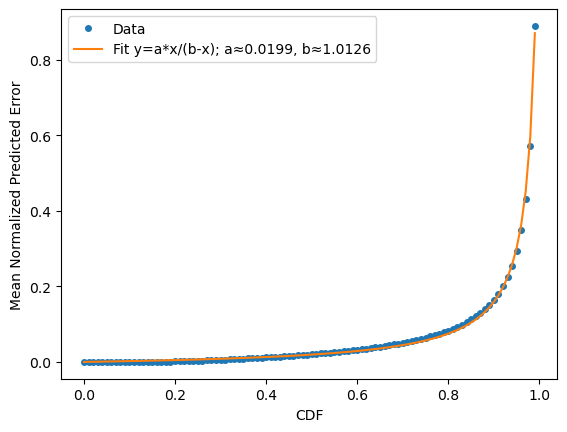

In [33]:
from scipy.optimize import curve_fit

def mmfunc(x, a, b):
    return 1*x/(b+x)

def inv_mmfunc_one_param(x, a):
    return a*x/(1-x)

def inv_mmfunc(x, a, b):
    return a*x/(b-x)

plot_errors = sorted_confpred[plot_idx_quantiles]

# popt1, pcov1 = curve_fit(inv_mmfunc_one_param, plot_quantiles, plot_errors)
# print(popt1)
popt2, pcov2 = curve_fit(inv_mmfunc, plot_quantiles, plot_errors)
print(popt2)
# popt = [1,1]

plt.plot(plot_quantiles, plot_errors, 'o', label='Data', ms=4)
# plt.plot(plot_quantiles, inv_mmfunc_one_param(plot_quantiles, *popt1), label=f'Fit y=a*x/(1-x); a≈{round(popt1[0],4)}')
plt.plot(plot_quantiles, inv_mmfunc(plot_quantiles, *popt2), label=f'Fit y=a*x/(b-x); a≈{round(popt2[0],4)}, b≈{round(popt2[1],4)}')
plt.xlabel('CDF')
plt.ylabel('Mean Normalized Predicted Error')
plt.legend()

# plt.savefig('../../Figures/error_prediction_columnaverage_fit_troposphere.jpg')
plt.show()
# plt.yscale('log')
# [0.00847742]
# [0.01699706 1.01534258]
# [0.01951723 1.01267799]
# [0.0199207  1.01263884]

### Use relative error

In [71]:
pred_relabserror = np.abs(np.divide(y_conf, y_preds, where=y_preds!=0))
real_relabserror = np.abs(np.divide(y_losses, y_trues, where=y_trues!=0))
real_maerelabserror = np.abs(np.divide(ymae_losses, y_trues, where=y_trues!=0))

pred_relabserror.shape, real_relabserror.shape, real_maerelabserror.shape

((1024000, 302), (1024000, 302), (1024000, 302))

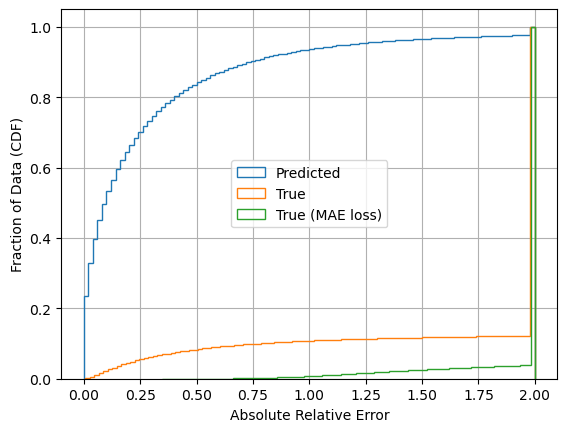

In [38]:
# pred_plot = np.clip(pred_relabserror[:,trop_mask].ravel(), 0, 1)
# real_plot = np.clip(real_relabserror[:,trop_mask].ravel(), 0, 1)
pred_plot = np.clip(np.mean(pred_relabserror[:,trop_mask], axis=1), 0, 2)
real_plot = np.clip(np.mean(real_relabserror[:,trop_mask], axis=1), 0, 2)
real_mae_plot = np.clip(np.mean(real_maerelabserror[:,trop_mask], axis=1), 0, 2)

plt.hist(pred_plot, bins=100, histtype='step', cumulative=True, density=True, label='Predicted')
plt.hist(real_plot, bins=100, histtype='step', cumulative=True, density=True, label='True')
plt.hist(real_mae_plot, bins=100, histtype='step', cumulative=True, density=True, label='True (MAE loss)')
# plt.hist(pred_plot, bins=100, range=(0,1))
# plt.hist(real_plot, bins=100, range=(0,1))
# plt.yscale('log')
plt.xlabel('Absolute Relative Error')
plt.ylabel('Fraction of Data (CDF)')
plt.legend()
plt.grid()

# plt.savefig('../../Figures/relabs_error_prediction_columnaverage_troposphere.jpg')
# plt.savefig('../../Figures/relabs_error_prediction_clipped_troposphere.jpg')

plt.show()

# Analyze tropopause from sample

In [86]:
v5cnv_nols_inputs = ['state_t',
                'state_rh',
                'state_qn',
                'liq_partition',
                'state_u',
                'state_v',
                # 'state_t_dyn',
                # 'state_q0_dyn',
                # 'state_u_dyn',
                # 'tm_state_t_dyn',
                # 'tm_state_q0_dyn',
                # 'tm_state_u_dyn',
                'state_t_prvphy',
                'state_q0001_prvphy',
                'state_qn_prvphy',
                'state_u_prvphy',
                'tm_state_t_prvphy',
                'tm_state_q0001_prvphy',
                'tm_state_qn_prvphy',
                'tm_state_u_prvphy',
                # 'pbuf_ozone', # outside of the upper troposphere lower stratosphere (UTLS, corresponding to indices 5-21), variance in minimal for these last 3 
                # 'pbuf_CH4',
                # 'pbuf_N2O',
                'state_pmid',
                'state_ps',
                # 'pbuf_SOLIN',
                'pbuf_LHFLX',
                'pbuf_SHFLX',
                'pbuf_TAUX',
                'pbuf_TAUY',
                'pbuf_COSZRS',
                'cam_in_ALDIF',
                'cam_in_ALDIR',
                'cam_in_ASDIF',
                'cam_in_ASDIR',
                # 'cam_in_LWUP',
                # 'cam_in_ICEFRAC',
                # 'cam_in_LANDFRAC',
                # 'cam_in_OCNFRAC',
                # 'cam_in_SNOWHICE',
                # 'cam_in_SNOWHLAND',
                'tm_state_ps',
                # 'tm_pbuf_SOLIN',
                'tm_pbuf_LHFLX',
                'tm_pbuf_SHFLX',
                'tm_pbuf_COSZRS',
                # 'clat',
                # 'slat',
                # 'icol',
] 

v5cnv_outputs = ['ptend_t',
                 'ptend_q0001',
                 'ptend_qn',
                 'ptend_u',
                 'ptend_v',
                #'cam_out_NETSW',
                #'cam_out_FLWDS',
                 'cam_out_PRECSC',
                 'cam_out_PRECC',
                #'cam_out_SOLS',
                #'cam_out_SOLL',
                #'cam_out_SOLSD',
                #'cam_out_SOLLD'
]

In [98]:
# load v5cnv norms without lat/lon info
inp_sub = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_nols_nolatlon/inp_sub.txt', delimiter=',')
inp_div = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_nols_nolatlon/inp_div.txt', delimiter=',')
out_scale = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv/out_scale.txt', delimiter=',')

qn_lbd = np.loadtxt('/work/bd1179/b309215/ClimSim/preprocessing/normalizations/inputs/qn_exp_lambda_large.txt', delimiter=',')
# feature_lengths = [n_column_features, n_scalar_features]

# print(inp_div)
# inp_div[-1] = 21600 # change as icon has different number of cells in this setup and is normalized btw. 0 and 1, todo: check that again if using (at the moment not used anyways)
# # to v5cnv
# inp_sub = inp_sub[v5inputs_to_v5cnvnolsinputs_mask]
# inp_div = inp_div[v5inputs_to_v5cnvnolsinputs_mask]
# out_scale = out_scale[v5outputs_to_v5cnvoutputs_mask]
inp_sub.shape, inp_div.shape, out_scale.shape, qn_lbd.shape

((914,), (914,), (302,), (60,))

In [129]:
for b in val_loader:
    x,y = b
    print(x.shape)
    # undo input normalization
    x[:,:,0] = x[:,:,0] * inp_div[0*60:1*60] + inp_sub[0*60:1*60]
    x[:,:,14] = x[:,:,14] * inp_div[14*60:15*60] + inp_sub[14*60:15*60]
    break

torch.Size([1000, 60, 29])


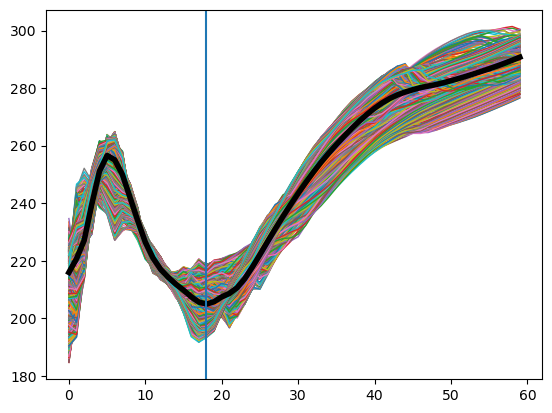

In [130]:
plt.plot(x[:,:,0].T, lw=1)
plt.plot(torch.mean(x[:,:,0], dim=0), lw=4, color='black')
plt.axvline(18)
plt.show()